In [4]:
print("TensorFlow version:", tf.__version__)
print("TF-Agents version:", tf_agents.__version__)

TensorFlow version: 2.12.0
TF-Agents version: 0.16.0


In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import tempfile
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
from typing import Optional, Callable, Text
import typing_extensions

from tf_prioritized_replay_buffer import TFPrioritizedReplayBuffer

from tf_agents.agents import tf_agent, data_converter
from tf_agents.agents.ddpg import ddpg_agent, actor_network, critic_network
from tf_agents.agents.td3 import td3_agent
from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.ppo import ppo_agent
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.agents.ddpg.actor_network import ActorNetwork
from tf_agents.networks import actor_distribution_network, value_network, q_network
from tf_agents.specs import tensor_spec
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory, time_step as ts
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies import actor_policy, greedy_policy, q_policy, epsilon_greedy_policy
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.drivers import dynamic_step_driver, dynamic_episode_driver
from tf_agents.distributions import utils as distribution_utils
from tf_agents.agents.sac import sac_agent
from tf_agents.typing import types
import collections
import gin
import tf_agents.networks as network

In [6]:
Literal = typing_extensions.Literal


class BehavioralCloningLossInfo(collections.namedtuple(
    'BehavioralCloningLossInfo', ('loss'))):
  pass


@gin.configurable
class BehavioralCloningAgent(tf_agent.TFAgent):
  

  def __init__(
      self,
      time_step_spec: ts.TimeStep,
      action_spec: types.NestedTensorSpec,
      cloning_network: network.Network,
      optimizer: types.Optimizer,
      num_outer_dims: Literal[1, 2] = 2,  # pylint: disable=bad-whitespace
      epsilon_greedy: types.Float = 0.1,
      loss_fn: Optional[Callable[[types.NestedTensor, bool],
                                 types.Tensor]] = None,
      gradient_clipping: Optional[types.Float] = None,
      # Params for debugging.
      debug_summaries: bool = False,
      summarize_grads_and_vars: bool = False,
      train_step_counter: Optional[tf.Variable] = None,
      name: Optional[Text] = None):
    
    tf.Module.__init__(self, name=name)
    self._cloning_network = cloning_network
    self._optimizer = optimizer
    self._gradient_clipping = gradient_clipping

    action_spec = tensor_spec.from_spec(action_spec)
    flat_action_spec = tf.nest.flatten(action_spec)
    continuous_specs = [tensor_spec.is_continuous(s) for s in flat_action_spec]

    if not flat_action_spec:
      raise ValueError('The `action_spec` must contain at least one action.')

    single_discrete_scalar_action = (
        len(flat_action_spec) == 1 and
        flat_action_spec[0].shape.rank == 0 and
        not tensor_spec.is_continuous(flat_action_spec[0]))
    single_continuous_action = (
        len(flat_action_spec) == 1 and
        tensor_spec.is_continuous(flat_action_spec[0]))

    if (not loss_fn and not single_discrete_scalar_action and
        not single_continuous_action):
      raise ValueError(
          'A `loss_fn` must be provided unless there is a single, scalar '
          'discrete action or a single (scalar or non-scalar) continuous '
          'action.')

    self._network_output_spec = cloning_network.create_variables(
        time_step_spec.observation)

    # If there is a mix of continuous and discrete actions we want to use an
    # actor policy so we can use the `setup_as_continuous` method as long as the
    # user provided a custom loss_fn which we verified above.
    if any(continuous_specs):
      policy, collect_policy = self._setup_as_continuous(
          time_step_spec, action_spec, loss_fn)
    else:
      policy, collect_policy = self._setup_as_discrete(time_step_spec,
                                                       action_spec, loss_fn,
                                                       epsilon_greedy)

    super(BehavioralCloningAgent, self).__init__(
        time_step_spec,
        action_spec,
        policy,
        collect_policy,
        train_sequence_length=None,
        debug_summaries=debug_summaries,
        summarize_grads_and_vars=summarize_grads_and_vars,
        train_step_counter=train_step_counter)

    self._as_trajectory = data_converter.AsTrajectory(
        self.data_context, sequence_length=None,
        num_outer_dims=num_outer_dims)

  @property
  def cloning_network(self):
    return self._cloning_network

  def _discrete_loss(self, experience, training=False):
    batch_size = (
        tf.compat.dimension_value(experience.step_type.shape[0]) or
        tf.shape(experience.step_type)[0])

    network_state = self._cloning_network.get_initial_state(batch_size)
    action, _ = self._cloning_network(
        experience.observation,
        step_type=experience.step_type,
        training=training,
        network_state=network_state)

    # Get logits if the output of the cloning network is a distribution.
    if isinstance(action, tfp.distributions.Distribution):
      bc_logits = action.logits_parameter()
    else:
      bc_logits = action

    def loss(action, bc_logits, spec):
      # Subtract the minimum so that we get a proper cross entropy loss on
      # [0, maximum - minimum).
      return tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=action - spec.minimum, logits=bc_logits)

    losses = tf.nest.map_structure(loss, experience.action, bc_logits,
                                   self.action_spec)
    losses = tf.nest.flatten(losses)
    return tf.add_n(losses)

  def _continuous_loss_fn(self, experience, training: bool = False):
    batch_size = (
        tf.compat.dimension_value(experience.step_type.shape[0]) or
        tf.shape(experience.step_type)[0])
    network_state = self._cloning_network.get_initial_state(batch_size)
    bc_output, _ = self._cloning_network(
        experience.observation,
        step_type=experience.step_type,
        training=training,
        network_state=network_state)

    if isinstance(bc_output, tfp.distributions.Distribution):
      bc_action = bc_output.sample()
    else:
      bc_action = bc_output

    losses = tf.nest.map_structure(tf.losses.mse, experience.action, bc_action)
    losses = tf.nest.flatten(losses)
    return tf.add_n(losses)

  def _setup_as_discrete(self, time_step_spec, action_spec, loss_fn,
                         epsilon_greedy):
    self._bc_loss_fn = loss_fn or self._discrete_loss

    if any(isinstance(d, distribution_utils.DistributionSpecV2) for
           d in tf.nest.flatten([self._network_output_spec])):
      # If the output of the cloning network contains a distribution.
      base_policy = actor_policy.ActorPolicy(time_step_spec, action_spec,
                                             self._cloning_network)
    else:
      # If the output of the cloning network is logits.
      base_policy = q_policy.QPolicy(
          time_step_spec,
          action_spec,
          q_network=self._cloning_network,
          validate_action_spec_and_network=False)
    policy = greedy_policy.GreedyPolicy(base_policy)
    collect_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
        base_policy, epsilon=epsilon_greedy)
    return policy, collect_policy

  def _setup_as_continuous(self, time_step_spec, action_spec, loss_fn):
    self._bc_loss_fn = loss_fn or self._continuous_loss_fn
    collect_policy = actor_policy.ActorPolicy(
        time_step_spec, action_spec, actor_network=self._cloning_network)
    policy = greedy_policy.GreedyPolicy(collect_policy)
    return policy, collect_policy

  def _loss(self, experience, weights=None, training: bool = False):
    experience = self._as_trajectory(experience)

    per_example_loss = self._bc_loss_fn(experience, training=training)  # pytype: disable=wrong-keyword-args  # dynamic-method-lookup
    aggregated_losses = common.aggregate_losses(
        per_example_loss=per_example_loss,
        sample_weight=weights,
        regularization_loss=self._cloning_network.losses)

    return tf_agent.LossInfo(
        loss=aggregated_losses.total_loss,
        extra=BehavioralCloningLossInfo(per_example_loss))

  def _train(self, experience, weights=None):
    experience = self._as_trajectory(experience)

    with tf.GradientTape() as tape:
      per_example_loss = self._bc_loss_fn(experience, training=True)  # pytype: disable=wrong-keyword-args  # dynamic-method-lookup

      aggregated_losses = common.aggregate_losses(
          per_example_loss=per_example_loss,
          sample_weight=weights,
          regularization_loss=self._cloning_network.losses)

    self._apply_loss(aggregated_losses,
                     variables_to_train=self._cloning_network.trainable_weights,
                     tape=tape,
                     optimizer=self._optimizer)

    self.train_step_counter.assign_add(1)
    return tf_agent.LossInfo(aggregated_losses.total_loss,
                             BehavioralCloningLossInfo(per_example_loss))

### TRAIN A DDPG (DEEP DETERMINISTIC POLICY GRADIENT) AGENT TO SOLVE PENDULUM-V1

In [7]:
env_name = 'Pendulum-v1'
train_env = suite_gym.load(env_name)
train_env = tf_py_environment.TFPyEnvironment(train_env)

In [8]:
eval_env_name = 'Pendulum-v1'
eval_env = suite_gym.load(eval_env_name)
eval_env = tf_py_environment.TFPyEnvironment(eval_env)

In [9]:
# Parameters
num_iterations = 10000
initial_collect_steps = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000
batch_size = 64
learning_rate = 1e-3
log_interval = 200
eval_interval = 1000
num_eval_episodes = 10 

In [17]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

In [11]:
global_step = tf.compat.v1.train.get_or_create_global_step()

In [21]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [22]:
def plot_results(losses, average_returns):
    # Convert actions_taken to a 1D list
    # actions_taken = [item[0][0] for item in actions_taken]

    # Plotting actions taken
    plt.figure()
    plt.plot(actions_taken)
    plt.title('Actions over time')
    plt.xlabel('Time step')
    plt.ylabel('Action')
    plt.show()

    # Plotting losses
    steps, loss_vals = zip(*losses)
    plt.figure()
    plt.plot(steps, loss_vals)
    plt.title('Loss over time')
    plt.xlabel('Time step')
    plt.ylabel('Loss')
    plt.show()

    # Plotting average returns
    steps, avg_returns = zip(*average_returns)
    plt.figure()
    plt.plot(steps, avg_returns)
    plt.title('Average Return over time')
    plt.xlabel('Time step')
    plt.ylabel('Average Return')
    plt.show()

In [38]:
# Collect data
def collect_episode(environment, policy, num_episodes, replay_buffer):

    episode_counter = 0
    environment.reset()

    while episode_counter < num_episodes:
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)

        if traj.is_boundary():
            episode_counter += 1

### SAC

In [23]:
# Parameters
num_iterations = 10000
initial_collect_steps = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000
batch_size = 64
learning_rate = 1e-3
log_interval = 50
eval_interval = 500
num_eval_episodes = 10 

# Hyperparameters
critic_learning_rate = 3e-4
actor_learning_rate = 3e-4
alpha_learning_rate = 3e-4
target_update_tau = 0.005
target_update_period = 1
gamma = 0.99
reward_scale_factor = 1.0
gradient_clipping = None
debug_summaries = False
summarize_grads_and_vars = False

In [24]:
# Actor network
sac_actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(256, 256))

In [25]:
# Critic network
sac_critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(), train_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=(256, 256))

In [26]:
# SAC Agent
global_step = tf.compat.v1.train.get_or_create_global_step()
sac_tf_agent = sac_agent.SacAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=sac_actor_net,
    critic_network=sac_critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
sac_tf_agent.initialize()

In [27]:
# Replay Buffer
sac_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=sac_tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [28]:
for _ in range(100):
    collect_step(train_env, sac_tf_agent.collect_policy, sac_replay_buffer)

In [29]:
sac_dataset = sac_replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=64, 
    num_steps=2).prefetch(3)

sac_iterator = iter(sac_dataset)

In [31]:
# Variables to store data for plotting
losses = []
average_returns = []
episode_lengths = []


# Reset the train step counter
sac_tf_agent.train_step_counter.assign(0)

# For tracking episode length
episode_length = 0

# Assuming `num_iterations` is the total number of training steps
for _ in (range(num_iterations)):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, sac_tf_agent.collect_policy, sac_replay_buffer)

    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      episode_lengths.append(episode_length)
      episode_length = 0
    else:
      episode_length += 1

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(sac_iterator)
  train_loss = sac_tf_agent.train(experience).loss

  step = sac_tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
    losses.append((step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, sac_tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    average_returns.append((step, avg_return))

step = 50: loss = 10.672172546386719
step = 100: loss = 10.46866512298584
step = 150: loss = 11.088735580444336
step = 200: loss = 11.53530216217041
step = 250: loss = 14.474116325378418
step = 300: loss = 16.38463020324707
step = 350: loss = 18.65925407409668
step = 400: loss = 53.10423278808594
step = 450: loss = 13.975921630859375
step = 500: loss = 24.94031524658203
step = 500: Average Return = -1350.1533203125
step = 550: loss = 26.677846908569336
step = 600: loss = 24.115528106689453
step = 650: loss = 26.4414005279541
step = 700: loss = 27.785032272338867
step = 750: loss = 29.596153259277344
step = 800: loss = 43.45854568481445
step = 850: loss = 28.764270782470703
step = 900: loss = 32.71876525878906
step = 950: loss = 32.57664108276367
step = 1000: loss = 45.84013748168945
step = 1000: Average Return = -1543.3216552734375
step = 1050: loss = 33.49080276489258
step = 1100: loss = 36.93902587890625
step = 1150: loss = 32.75144577026367
step = 1200: loss = 36.85957336425781
step

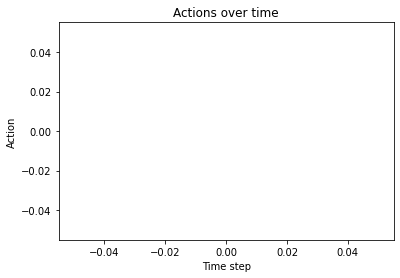

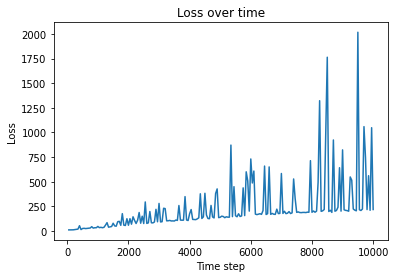

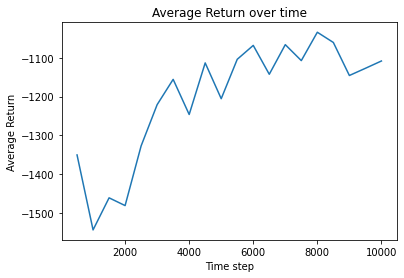

In [32]:
plot_results(losses,average_returns)

### PPO

In [33]:
ppo_actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(100,))
ppo_value_net = value_network.ValueNetwork(train_env.observation_spec())

In [34]:
# Agent
ppo_tf_agent = ppo_agent.PPOAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    actor_net=ppo_actor_net,
    value_net=ppo_value_net,
    num_epochs=10)
ppo_tf_agent.initialize()

In [35]:
# Metrics and Evaluation
ppo_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=ppo_tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
ppo_dataset = ppo_replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
ppo_iterator = iter(ppo_dataset)

In [36]:
# Training loop
ppo_tf_agent.train = common.function(ppo_tf_agent.train)
ppo_tf_agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=0>

In [39]:
# Variables to store data for plotting
ppo_losses = []
ppo_average_returns = []
ppo_episode_lengths = []

# For tracking episode length
ppo_episode_length = 0

print(num_iterations)


# Wrap the training loop in tqdm
# pbar = (range(num_iterations))
for _ in (range(num_iterations)):
# with tf.device('/GPU:0'):
    # for _ in pbar:
    # Collect a few episodes using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_episode(train_env, ppo_tf_agent.collect_policy, 1, ppo_replay_buffer)

    # Use data from the buffer and update the agent's network.
    experience, unused_info = next(ppo_iterator)
    train_loss = ppo_tf_agent.train(experience).loss

    step = ppo_tf_agent.train_step_counter.numpy()
    
    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        ppo_losses.append((step, train_loss))
    
    # Store metrics
    # ppo_losses.append(train_loss)

    # Update progress bar
    # pbar.set_description(f'Step: {step}, Loss: {train_loss}')

    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      ppo_episode_lengths.append(episode_length)
      ppo_episode_length = 0
    else:
      ppo_episode_length += 1

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, ppo_tf_agent.policy, num_eval_episodes)
        ppo_average_returns.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))

# Print metrics
print(f'Final Loss: {ppo_losses[-1]}')
print(f'Final Average Return: {ppo_average_returns[-1]}')
print(f'Final Average Episode Length: {np.mean(ppo_episode_lengths)}')

2000


NameError: name 'behavioral_ddpg_agent' is not defined

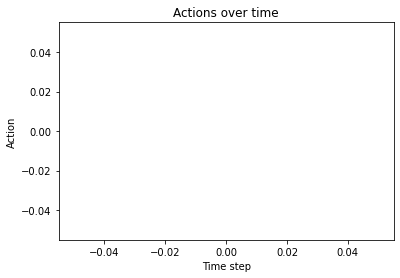

ValueError: not enough values to unpack (expected 2, got 0)

In [55]:
plot_results(ppo_losses,ppo_average_returns)

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def ppo_plot_results(average_returns):
    # Plotting losses
    # plt.figure()
    # plt.plot(losses)
    # plt.xlabel("Step")
    # plt.ylabel("Loss")
    # plt.title("Losses")

    # Plotting average returns
    steps = np.arange(len(average_returns))
    avg_returns = np.array(average_returns)

    plt.figure()
    plt.plot(steps, avg_returns)
    plt.title('Average Return over time')
    plt.xlabel('Time step')
    plt.ylabel('Average Return')
    plt.show()

### DDPG

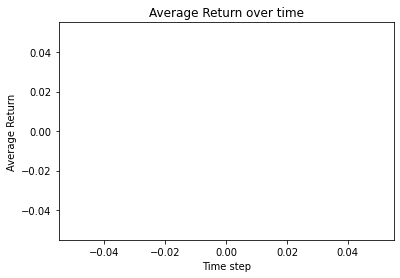

In [57]:
ppo_plot_results(ppo_average_returns)

In [ ]:
ddpg_actor_net = actor_network.ActorNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(400, 300))

ddpg_critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(), train_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=(400, 300))

In [ ]:
global_step = tf.compat.v1.train.get_or_create_global_step()

In [56]:
tf_ddpg_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    ou_stddev=0.2,
    ou_damping=0.15,
    target_update_tau=0.05,
    target_update_period=5,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=global_step)
tf_ddpg_agent.initialize()

In [45]:
ddpg_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_ddpg_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000)

In [46]:
for _ in range(100):
    collect_step(train_env, tf_ddpg_agent.collect_policy, ddpg_replay_buffer)

In [49]:
dataset = ddpg_replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=64, 
    num_steps=2).prefetch(3)

ddpg_iterator = iter(dataset)

In [52]:
# Variables to store data for plotting
actions_taken = []
losses = []
average_returns = []
episode_lengths = []

# For tracking episode length
episode_length = 0
num_iterations = 2000
# Reset the train step counter
tf_ddpg_agent.train_step_counter.assign(0)
# Assuming `num_iterations` is the total number of training steps
for _ in (range(num_iterations)):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, tf_ddpg_agent.collect_policy, ddpg_replay_buffer)

    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      episode_lengths.append(episode_length)
      episode_length = 0
    else:
      episode_length += 1

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(ddpg_iterator)
  train_loss = tf_ddpg_agent.train(experience).loss

  step = tf_ddpg_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
    losses.append((step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_ddpg_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    average_returns.append((step, avg_return))

step = 50: loss = 9.020744323730469
step = 100: loss = 2.6976239681243896
step = 150: loss = 4.308686256408691
step = 200: loss = 0.6016382575035095
step = 250: loss = 8.51148796081543
step = 300: loss = 1.7472211122512817
step = 350: loss = 24.179288864135742
step = 400: loss = 2.007106304168701
step = 450: loss = 2.114631414413452
step = 500: loss = 31.26702117919922
step = 500: Average Return = -1475.3612060546875
step = 550: loss = 32.11244201660156
step = 600: loss = 2.1875152587890625
step = 650: loss = 70.00251770019531
step = 700: loss = 2.071514844894409
step = 750: loss = 4.5519843101501465
step = 800: loss = 3.7574474811553955
step = 850: loss = 6.998297691345215
step = 900: loss = 3.620455026626587
step = 950: loss = 3.6113462448120117
step = 1000: loss = 3.008810520172119
step = 1000: Average Return = -1385.6580810546875
step = 1050: loss = 53.40069580078125
step = 1100: loss = 6.492674827575684
step = 1150: loss = 158.7423858642578
step = 1200: loss = 8.997446060180664
st

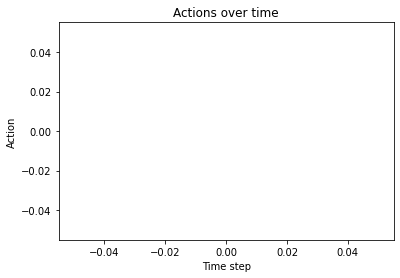

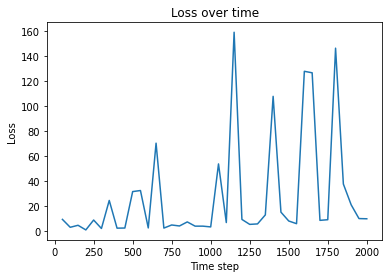

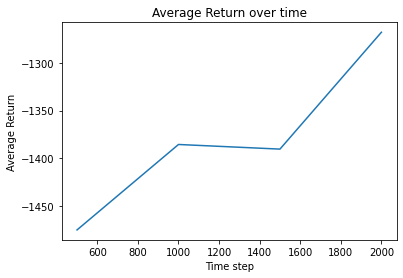

In [54]:
plot_results(losses, average_returns)

## NOW THAT THE DDQN AGENT HAS A BETTER POLICY TO INTERACT WITH THE ENVIRONMENT, LETS COLLECT SOME MORE EXPERIENCES AND STORE IT IN A NEW REPLAY BUFFER. THIS IS THE SET OF EXPERIENECS THAT THE BEHAVIORAL CLONING AGENT WILL LEARN FROM.

In [60]:
# Create a replay buffer to store trajectories
training_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_ddpg_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
max_interactions = 1000
num_interactions = 0
while num_interactions < max_interactions:
    time_step = train_env.reset()
    episode_step = 0
    while not time_step.is_last():
        action_step = tf_ddpg_agent.collect_policy.action(time_step)  # Use agent's collect_policy
        next_time_step = train_env.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        training_replay_buffer.add_batch(traj)

        time_step = next_time_step
        episode_step += 1
        num_interactions += 1

        if episode_step >= train_env.pyenv.envs[0].env.spec.max_episode_steps:
            break

# Print the number of interactions and replay buffer size
print(f'Number of interactions: {num_interactions}')
print(f'Replay buffer size: {training_replay_buffer.num_frames().numpy()}')

Number of interactions: 1000
Replay buffer size: 1000


## INITIALIZE BEHAVIORAL CLONING AGENT

In [61]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()

In [62]:
# Initialize the Actor Distribution Network
behavioral_actor_net = actor_network.ActorNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(400, 300))

In [63]:
# Optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

In [64]:
# Initialize the Behavioral Cloning Agent
train_step_counter = tf.Variable(0)
agent_b = BehavioralCloningAgent(
    time_step_spec=ts.time_step_spec(observation_spec),
    action_spec=action_spec,
    cloning_network=behavioral_actor_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter)

In [66]:
# Convert the replay buffer to a TensorFlow dataset
experience_dataset = training_replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=64,
    num_steps=1).prefetch(3)

In [67]:
experience_dataset_iterator = iter(experience_dataset)

In [68]:
# Make the Behavioral Cloning Agent's train function a TensorFlow graph function
agent_b.train = common.function(agent_b.train)

In [69]:
# Run the training loop
num_iterations = 10000  # adjust this to your needs
# Create a list to store the loss values
train_loss_list = []
for i in range(num_iterations):
    # Sample a batch of experiences from the replay buffer
    trajectories, _ = next(experience_dataset_iterator)
    
    # Train the agent on the sampled experiences
    train_loss = agent_b.train(trajectories)
    
    # Append the current loss value to the list
    train_loss_list.append(train_loss.loss)
    
    # Print the current iteration number and the training loss every 100 iterations
    if i % 100 == 0:
        print('Iteration:', i, 'Training loss:', train_loss.loss.numpy())

Iteration: 0 Training loss: 0.96402586
Iteration: 100 Training loss: 0.89661187
Iteration: 200 Training loss: 0.7933061
Iteration: 300 Training loss: 1.0795138
Iteration: 400 Training loss: 0.9139008
Iteration: 500 Training loss: 0.78941053
Iteration: 600 Training loss: 0.5759878
Iteration: 700 Training loss: 0.72493947
Iteration: 800 Training loss: 0.79719543
Iteration: 900 Training loss: 0.9585149
Iteration: 1000 Training loss: 0.71828264
Iteration: 1100 Training loss: 0.60094506
Iteration: 1200 Training loss: 0.97459865
Iteration: 1300 Training loss: 0.6196072
Iteration: 1400 Training loss: 0.69558495
Iteration: 1500 Training loss: 0.8239915
Iteration: 1600 Training loss: 0.53045917
Iteration: 1700 Training loss: 0.9099802
Iteration: 1800 Training loss: 0.85285133
Iteration: 1900 Training loss: 0.73918
Iteration: 2000 Training loss: 0.7265477
Iteration: 2100 Training loss: 0.90196943
Iteration: 2200 Training loss: 0.73478425
Iteration: 2300 Training loss: 0.75547856
Iteration: 2400 

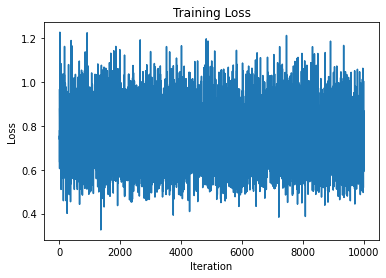

In [70]:
# Plot the training loss
plt.plot(train_loss_list)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## LET'S FIND OUT IF OUT BEHAVIORAL CLONING AGENT INTERACTS WITH CARTPOLE BETTER AFTER TRAINING ON THE REPLAY BUFFER FULL OF EEXPERIENCES

In [73]:
# Reset the environment
eval_env.reset()

# Initialize variables
total_reward = 0
rewards = []
average_rewards = []
num_eval_episodes = 1000
# Collect rewards by interacting with the environment
for step in range(num_eval_episodes):
    print(step)
    time_step = eval_env.current_time_step()
    while not time_step.is_last():
        # Get the agent's action based on the current time step
        action_step = agent_b.policy.action(time_step)
        
        # Apply the action to the environment
        next_time_step = eval_env.step(action_step.action)
        
        # Collect the reward
        reward = next_time_step.reward
        total_reward += reward
        
        # Update the time step
        time_step = next_time_step
    
    # Append the total reward for the episode
    rewards.append(total_reward)
    total_reward = 0
    
    # Calculate the average reward
    average_reward = sum(rewards) / len(rewards)
    average_rewards.append(average_reward)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

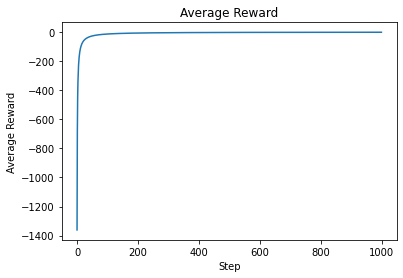

In [74]:

# Plot the final average reward
plt.plot(average_rewards)
plt.title('Average Reward')
plt.xlabel('Step')
plt.ylabel('Average Reward')
plt.show()

In [79]:
# Define a function to collect experiences
def collect_experience(environment, policy, buffer, num_episodes):
    counter = 0
    for _ in range(num_episodes):
        print(counter)
        counter += 1
        time_step = environment.reset()
        while not time_step.is_last():
    
            action_step = policy.action(time_step)
            next_time_step = environment.step(action_step.action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            buffer.add_batch(traj)
            time_step = next_time_step

In [75]:
# Initialize the Critic Network
behavioral_critic_net = critic_network.CriticNetwork(
    (observation_spec, action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=(100,))

In [76]:
behavioral_ddpg_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=behavioral_actor_net,
    critic_network=behavioral_critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    ou_stddev=0.2,
    ou_damping=0.15,
    target_update_tau=0.05,
    target_update_period=5,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=global_step)
behavioral_ddpg_agent.initialize()

In [77]:
per_replay_buffer = TFPrioritizedReplayBuffer(
    data_spec=behavioral_ddpg_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [80]:
# Collect experiences using the behavioral cloning agent
num_eval_episodes = 100
collect_experience(eval_env, agent_b.policy, per_replay_buffer, num_eval_episodes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [81]:
# Reset the train environment
train_env.reset()

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.27361265,  0.96184   ,  0.64379686]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})

In [82]:
# Create an iterator for the replay buffer
behavioral_dataset = per_replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=64, num_steps=2)
behavioral_dataset = behavioral_dataset.prefetch(3)
iterator = iter(behavioral_dataset)

In [83]:
# Variables to store data for plotting
behavioral_losses = []
behavioral_average_returns = []
behavioral_episode_lengths = []

# Reset the train step counter
behavioral_ddpg_agent.train_step_counter.assign(0)

# For tracking episode length
episode_length = 0
num_iterations = 2000
num_eval_episodes = 20

# Assuming `num_iterations` is the total number of training steps
for _ in (range(num_iterations)):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent_b.collect_policy, per_replay_buffer)

    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      behavioral_episode_lengths.append(episode_length)
      episode_length = 0
    else:
      episode_length += 1

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(ddpg_iterator)
  train_loss = behavioral_ddpg_agent.train(experience).loss

  step = behavioral_ddpg_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
    behavioral_losses.append((step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, behavioral_ddpg_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    behavioral_average_returns.append((step, avg_return))

step = 50: loss = 23.48270606994629
step = 100: loss = 9.898577690124512
step = 150: loss = 6.218648433685303
step = 200: loss = 8.860520362854004
step = 250: loss = 4.246285438537598
step = 300: loss = 3.3806779384613037
step = 350: loss = 4.203214645385742
step = 400: loss = 6.291819095611572
step = 450: loss = 2.7536416053771973
step = 500: loss = 2.026233434677124
step = 500: Average Return = -1467.5579833984375
step = 550: loss = 5.065988063812256
step = 600: loss = 2.387199640274048
step = 650: loss = 1.6605252027511597
step = 700: loss = 2.3283143043518066
step = 750: loss = 4.157009601593018
step = 800: loss = 15.983663558959961
step = 850: loss = 4.929522514343262
step = 900: loss = 18.24879264831543
step = 950: loss = 4.388525009155273
step = 1000: loss = 20.84053611755371
step = 1000: Average Return = -1357.169189453125
step = 1050: loss = 4.306925296783447
step = 1100: loss = 3.864041566848755
step = 1150: loss = 5.166360378265381
step = 1200: loss = 8.829211235046387
step 

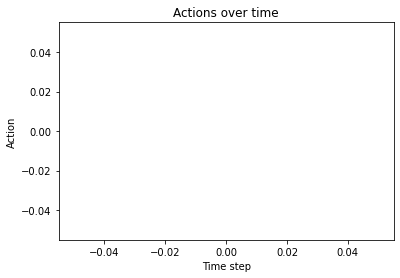

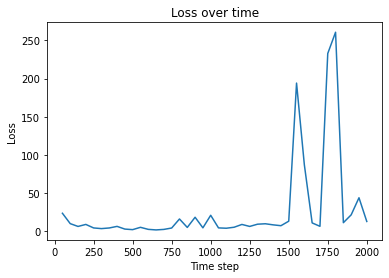

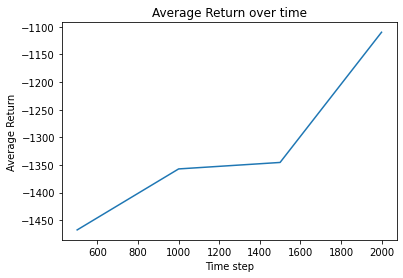

In [84]:
plot_results(behavioral_losses, behavioral_average_returns)